[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/witchapong/anime-review-classification/blob/main/anime-review-classification.ipynb)

In [1]:
import numpy as np
import pandas as pd
from fastai.text.all import *
import fastai
print(f"fastai version: {fastai.__version__}")
import matplotlib.pyplot as plt
from ipywidgets import interact
from collections import Counter

fastai version: 2.2.5


# Objective
- Classify review rating of Anime based text review using the dataset [MAL Top 10k Anime](https://www.kaggle.com/stoicstatic/mal-top-10k-anime-details?select=MAL+Anime+Top+10000+Details.csv)
- Utilize transfer learning for text classification task using fastai library

# Get the data

Register an account on [Kaggle](https://www.kaggle.com/) if you don't have one and get your API token. See [Public API](https://www.kaggle.com/docs/api) for the detail. Then uncomment, edit the variables to your credential detail, and run the below command set to fetch the data from Kaggle.

In [2]:
# !export KAGGLE_USERNAME=datadinosaur
# !export KAGGLE_KEY=xxxxxxxxxxxxxx
# !pip install kaggle
# !kaggle datasets download -d stoicstatic/mal-top-10k-anime-details

# Data exploration

In [3]:
reviews = pd.read_csv("/kaggle/input/mal-top-10k-anime-details/MAL Anime Reviews 85k.csv")

In [4]:
reviews.head()

,Anime Rank,Anime Title,Anime URL,Username,Review Date,Episodes Watched,Review Likes,Overall Rating,Story Rating,Animation Rating,Sound Rating,Character Rating,Enjoyment Rating,Review
0,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood/reviews,tazillo,"Jan 25, 2010",64 of 64 episodes seen,3464,10,10,9,9,10,10,"First of all, I have seen the original FMA and although it was very popular and original, the pacing and conclusion did not sit too well with me. Brotherhood is meant to be a remake of the original, this time sticking to the manga all the way through, but there were people who thought it would spoil the franchise. That myth should be dispelled, as there's only one word to describe this series - EPIC.\nI admit that as I've seen the original and read the manga, the pacing of Brotherhood seems to start off being VERY fast (I finally got used to the pacing after\nwatching the first fifteen eps..."
1,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood/reviews,Archaeon,"Nov 15, 2010",64 of 64 episodes seen,1311,9,8,9,9,9,9,"Adaptations have long been a thorn in the side of anime viewers, but not because they are inherently bad. No, the main problem has been that many studios have regarded the original work almost as an afterthought, and there are a number of shows that could have been wonderful if the writers had simply stuck to the original story.\nOne of the issues at hand seems to be ownership as producers, writers and directors all seem to want the work to be reflective of their style and perception, and in order to stamp their mark on a show they will makes numerous unnecessary changes or additions.\nAdm..."
2,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood/reviews,ChristopherKClaw,"Apr 7, 2015",64 of 64 episodes seen,1113,7,8,8,10,6,7,"Fullmetal Alchemist: Brotherhood gets an immense amount of praise in the MAL community, is the #1 ranked show and is constantly referred to as a masterpiece and the greatest show ever created. I've seen many fans preach about how ""it lives up to the hype"" and ""can never receive too much praise"". Now this is just the opinion of one guy. I'm certainly not the law of the land or anything. However, I personally feel as though calling FMA:B a masterpiece and the champion of all shows is a bit of a stretch. That's not to say that I didn't enjoy it or that it\nisn't a very solid addition to the r..."
3,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood/reviews,literaturenerd,"Apr 25, 2015",64 of 64 episodes seen,704,7,8,8,8,8,8,"Overview:\nFMA Brotherhood is an anime that needs no introduction. This is the highest rated anime on all of MAL. This is the anime that the current generation of anime fans holds above all others as the greatest single anime EVER made! In the following paragraphs, I will be reviewing this legendary series and discussing whether or not it truly deserves this title.\nSPOILERS for both Brotherhood and 2003 FMA!!!!\nPlot:\nThe plot takes place in the country of Armestris, which is basically like an alternate WW2 Germany. It is constantly at war for reasons that are less than just and is ruled..."
4,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood/reviews,M0nkeyD_Luffy,"Jul 29, 2015",64 of 64 episodes seen,446,5,2,7,7,8,5,"Since I couldn't find any legitimate objective analysis in any of these fanboy reviews, I decided put my own review:\nHere's why FMA:B and it's Manga counterpart don't work:\nIt's just a disjointed piece of art. The initial premise of the narrative: two young siblings that horrifically lose their mother and parts of themselves is incredibly dark and powerfully poignant. Their journey to find the philosophers stone is one that's objectively adventurous but the endpoint is still inherently adult

Convert data type of `Review Date` from string to `datetime` type

In [5]:
reviews["Review Date"] = pd.to_datetime(reviews["Review Date"])

Check out basic infos about the data

In [6]:
print(f"total reviews: {len(reviews)}")
print(f"unique animes: {reviews['Anime Title'].nunique()}")
print(f"unique users: {reviews['Username'].nunique()}")
print(f"review date from {reviews['Review Date'].min()} - {reviews['Review Date'].max()}")

total reviews: 85953
unique animes: 4315
unique users: 35118
review date from 2006-11-07 00:00:00 - 2020-11-16 00:00:00


Visualize how the distribution of `Overall Rating` as we will use this column as our classification label. We could observe from the plot that the overall rating leans toward high rating score.

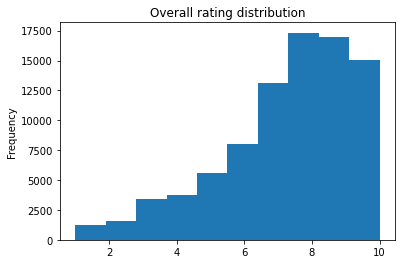

In [7]:
# overall rating distribution
_ = reviews["Overall Rating"].plot.hist()
_ = plt.title("Overall rating distribution")

Let's count total words of each review by splitting string using a single white space (`" "`) and visualize the distribution. It might be hard to look at the number on the x-axis on the plot as the data is right-skewed and has a long tail (there is a few review with very large total words). We could use the method `describe` on the calculated column `review_total_words` to look at important summary statistics. The median of total words of reviews is 372. We are dealing with pretty lengthy reviews!

In [8]:
# review word length
reviews["review_total_words"] = reviews["Review"].apply(lambda x: len(x.split(" ")))

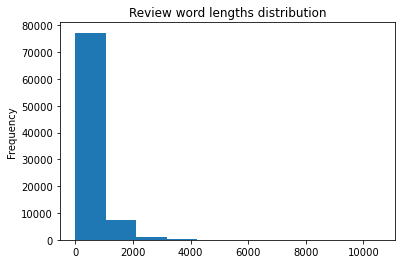

In [9]:
_ = reviews["review_total_words"].plot.hist()
_ = plt.title("Review word lengths distribution")

In [10]:
reviews["review_total_words"].describe()

count    85953.000000
mean       516.838551
std        495.528978
min          1.000000
25%        202.000000
50%        372.000000
75%        658.000000
max      10564.000000
Name: review_total_words, dtype: float64

Let's checkout distribution of total reviews per anime. Could you observe that most of the animes get less than 10 reviews and a few of them get more than 70 reviews?

In [11]:
# review per anime
review_per_anime = reviews.groupby("Anime Title")["Username"].count().reset_index()

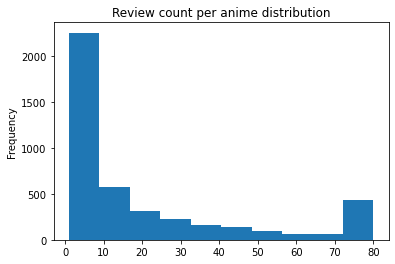

In [12]:
_ = review_per_anime["Username"].plot.hist()
_ = plt.title("Review count per anime distribution")

# Train model

We'll create fastai `DataLoaders` using the method `from_df` of `TextDataLoader`. With its default parameters, the data will be automatically splitted to training and validation set internally.

In [13]:
dls = TextDataLoaders.from_df(reviews,text_col="Review",label_col="Overall Rating")

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
dls.show_batch()

,text,category
0,"xxbos * english is xxup not my first language ! xxmaj review / analysis / rant will be edited … eventually ! * \n "" it 's like watching two kids playing with their favourite action figurines , yelling at each other why one is so much better than the other , while someone presses every other minute the pause - button , and holds them still for about five to ten minutes - this goes on and on for fifty hours or so , straight ! "" \n - xxmaj xxunk , after 50 episodes of xxup dbz \n xxmaj first of all , let me tell you a little story , about how i ended up losing 100 hours of my life , into this … anime . xxmaj first of all , i never saw this anime when i was a \n kid , so … no",1
1,"xxbos xxup warning : xxmaj this review contains spoilers for xxmaj last xxmaj exile . \n xxmaj man , i love steampunk , it 's probably my favorite type of aesthetic in all of fiction ever since i discovered it watching xxmaj laputa : xxmaj castle in the xxmaj sky , then i played xxmaj final xxmaj fantasy xxup vi and it consolidated my love for it . xxmaj unfortunately , there are n't too many good steampunk anime out there , though … xxmaj after watching xxmaj princess xxmaj principal a few years ago , i started to look for more steampunk anime , only to be disappointed by the likes of xxmaj steamboy and xxmaj kabaneri , which looked and sounded really cool , but lacked in every other substantial department . i also watched xxmaj baccano , which was pretty good , \n but not really the",8
2,xxbos xxmaj please note this review is intended to be read by those that have finished watching xxmaj record of xxmaj grancrest xxmaj war and while care has been taken to minimise story related spoilers there may still be spoilers within character analysis . xxmaj you have been warned . \n xxmaj based off a popular light novel of the same name xxmaj record of xxmaj grancrest xxmaj war is an action and fantasy anime that gives us the opportunity to see what will happen if a wandering knight and a powerful but determined mage were to unite their powers and gather like minded individuals to fight against both the rampant chaos that is causing endless wars across \n the land and the two large power blocks of countries that are taking advantage of the chaos to fight wars against each other . \n xxmaj but rather than fight for,10
3,"xxbos xxmaj intro \n xxmaj twin stars ’ exorcist or its official name xxmaj sousei no xxmaj onmyouji is based off the popular manga of the same name and is a direct adaption of it . xxmaj at 50 episodes , long this is one of the longer animes that i have seen recently as most animes these days are not as long as they used to be . xxmaj so far , the longest running animes that i seen since i started watching animes have been at 366 episodes long and xxmaj fairy tail to which the number is probably higher but i have yet to finish that one . xxmaj at 50 episodes , long xxmaj twin suns is around \n just over two full seasons of 24 episodes each . \n xxmaj twin star ’s exorcist is an action / fantasy anime with some supernatural elements thrown",9
4,"xxbos xxmaj spoilers and a lot of them . xxmaj read with caution . \n xxmaj how do you tell a good story ? xxmaj what defines a bad story ? xxmaj who is the audience and what is the message of your story ? xxmaj these are questions an author must face when writing his story – the author must answer all of these questions beforehand in order to tell his story in an understandable way . i believe that every story , no matter what medium or genre it is in , needs a core message – a message that the audience can understand – that is , undoubtedly , what tells a good story from a bad one . \n xxmaj we ’re all familiar with \n different stories ; we ’ve read , seen and heard countless of stories ; stories that spark interest and evoke",5
5,"xxbos ( this review has been adapted from my blog / reddit thread . xxmaj spoilers ahead ! ) \n xxmaj the semicolon gets a bad rap . \n xxmaj most day -

Next, we'll create fastai `Learner` using the function `text_classifier_learner`. Here, we'll specify a neural network architect of a pretrained model to be `AWD_LSTM` which is just another variant of a RNN architect. For more information regarding this architecture, visit [AWD-LSTM](https://docs.fast.ai/text.models.awdlstm.html). Finally, we'll train the model using the `fine_tune` method which automatically freeze the rest of the network and only train the last layer (also called the "head") for one epoch (by default) and then unfreeze the whole network and train for the specified number of epochs.

In [15]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [16]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.795568,1.746143,0.293834,08:44


epoch,train_loss,valid_loss,accuracy,time
0,1.383687,1.259344,0.489645,19:16
1,1.250813,1.150077,0.531763,19:18
2,1.115756,1.101975,0.553287,19:17
3,1.086331,1.095917,0.559395,19:20


# Evaluation

In [17]:
learn.show_results()

,text,category,category_
0,"xxbos xxmaj please note this review is intended to be read by those that have finished watching xxmaj rascal xxmaj does xxmaj not xxmaj dream of xxmaj bunny xxmaj girl xxmaj sempai and while care has been taken to minimize story related spoilers there may still be spoilers within character analysis . xxmaj you have been warned . \n xxmaj based off a popular light novel of the same name xxmaj seishun xxmaj buta xxmaj yarou xxmaj wa xxmaj bunny xxmaj girl xxmaj sempai xxmaj no xxmaj yume xxmaj wo xxmaj minai which is better known by its xxmaj english title xxmaj rascal xxmaj does not xxmaj dream of xxmaj bunny xxmaj girl xxmaj sempai is a romance , comedy , supernatural and school genre anime that gives us the opportunity to see what will happen if a teenage \n boy who always approached his life with cynicism due to",10,10
1,"xxbos xxmaj dragonball z with swords . xxmaj this is how xxmaj i 've seen many people describe xxmaj claymore . \n xxmaj but the truth is , the only similarity between these two shows is that they are both action packed power - up series ( however , the power - up element in xxmaj claymore is absolutely nothing compared to xxup dbz ) . \n xxmaj it would be much more accurate to compare xxmaj claymore with xxmaj berserk . xxmaj in 1998 , xxmaj berserk came to define the violent , graphic dark - fantasy genre in anime , and xxmaj claymore took its mantle for the first decade of the 21st century . xxmaj both share many similarities - from medieval - style settings , serious and dark tone to giant swords and plenty of uncensored gore . xxmaj indeed , with \n its huge count",8,8
2,"xxbos xxmaj this show is cute . \n i do n't know why it took me three entire seasons to get this , but it 's true . xxmaj the reason why i enjoy this show so much is because it is cute . xxmaj there is no other way to say this . xxmaj the main appeal of this show and the reason why it is so dearly loved by the few who watch it is its cuteness . xxmaj cuteness is its heart , body , and soul ; its very essence . xxmaj cuteness is the bone of its sword . xxmaj adorable is its body and kawaii is its blood . xxmaj every single aspect of this show contributes , has contributed , and shall continue to contribute \n to its cuteness . xxmaj everything that does n't radiate with cuteness shall be considered a flaw",7,8
3,"xxbos xxmaj i 'll start this review off by saying xxmaj i 'm not really breaking new ground here telling people what they already know , that this show is n't that good . xxmaj so to somewhat be a contrarian for the sake of making myself seem more important , xxmaj i 'll state that i think there are more problems with the show than it just being a bad adaption of a browser game story or being too literal of an adaption of said story and thus displeasing "" mainstream "" anime audience goers in favor of diehard players of the game . i actually think the problems with this show runs much deeper than that . xxmaj well … xxmaj as \n deep as a show about animu girl warships can be , which is about the depth of a bowl of ramen , but still i",1,4
4,"xxbos ( this has been adapted from my blog / reddit thread . xxmaj spoilers ahead ! ) \n xxmaj gangsta . makes me , naturally , think of the word “ gangster ” . i am not a gangster myself , much to the surprise of everyone who knows me . xxmaj to be honest , i am not sure where that line is drawn . i like mathematics , but that does not mean a gangster can not like derivatives and xxunk , too . xxmaj the opposite it true as well ; i might not do hard drugs but i certainly love caffeine . \n i was in a gang once , though not the gruff , cool type . xxmaj our gang was called “ the xxmaj five xxmaj musketeers ” . xxmaj it was me and my four best friends in \n elementary school .",6,6
5,"xxbos [ this review covers all seasons of xxmaj ojamajo xxmaj doremi , meant as an extensive coverage of the series ] \n xxmaj passion . a compelling desire towards something ; som

Let's extract the predicted probabilities (or we could say probability distribution of each classes-review rating from 1-10, in this case) and corresponded target for model evaluation.

In [18]:
preds, targs = learn.get_preds()

**Confusion matrix** : let's plot a confusion matrix to take a closer look whether the model predictions align with the actual rating.

In [28]:
from fastai.interpret import ClassificationInterpretation

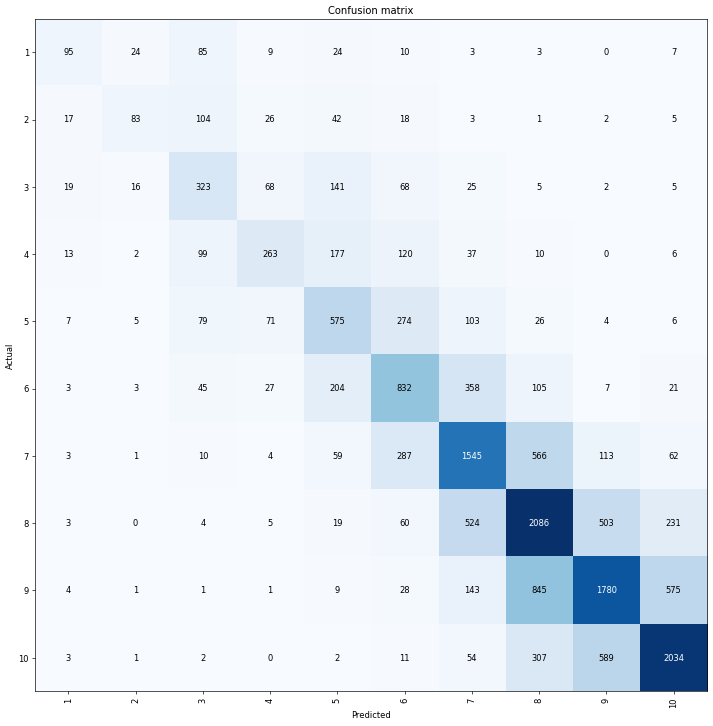

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp = interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Here, we compute our model classification accuracy by comparing `argmax` of the predicted probabilities with the target and take the mean.

In [19]:
model_acc = (torch.argmax(preds,1) == targs).float().mean().item() * 100

In [20]:
print(f"model accuracy: {model_acc}")

model accuracy: 55.93950152397156


We'll compute baseline accuracy using most voted overall rating from the training set to predict validation set review rating.

In [21]:
most_voted_overall_rating = Counter(dls.train_ds.items["Overall Rating"].values).most_common(1)[0][0]

In [22]:
print(f"most voted overall rating: {most_voted_overall_rating}")

most voted overall rating: 8


In [23]:
naive_baseline_acc = (dls.valid_ds.items["Overall Rating"] == most_voted_overall_rating).mean() * 100

Compare accuracies

In [24]:
print(f"naive baseline accuracy: {naive_baseline_acc}")
print(f"naive baseline accuracy: {naive_baseline_acc}")

naive baseline accuracy: 19.9825479930192
naive baseline accuracy: 19.9825479930192


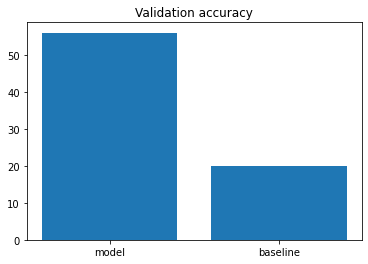

In [25]:
_ = plt.bar(x=['model','baseline'] ,height=[model_acc, naive_baseline_acc])
_ = plt.title('Validation accuracy')

# Inference

Finally, let's make a widget for inputing Anime review and outputing an overall rating.

In [26]:
def get_learn_pred(txt):
    
    preds = learn.predict(txt)
    return f"Predicted review rating is {preds[0]}."

In [27]:
_ = interact(get_learn_pred, txt="This is genuinely genius. How could the plot got twisted like this! Gonna watch two more rounds.")

interactive(children=(Text(value='This is genuinely genius. How could the plot got twisted like this! Gonna wa…